In [284]:
from math import pi, sqrt, e, log, isclose, exp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.constants import epsilon_0, mu_0

In [37]:
#Max sneeze particle velocity is 6 m/s. [Nishimura 2013]

#the particle can travel 0.005 m per pulse.

max_velocity = 6.0 
max_allowable_distance = 0.005 #m
max_interval = max_allowable_distance/max_velocity

repetition_freq = 1.0/max_interval


pulse_duration = 100e-9 #seconds


duty_cycle = repetition_freq * pulse_duration 

pulse_power_draw = 2.0*80e-3 # volts * amps - not equivalent to the RF output power, do note

average_power = duty_cycle * pulse_power_draw #watts

#battery_capacity = 0.1575 #watt-hours - a single LR44 zinc cell
battery_capacity = 1.725

battery_life_months = (battery_capacity / average_power) / 24 / 30 # months



In [36]:
pulse_RF_output_power_watts = 10 # watts

exposure_area = (0.01**2.0) #m

exposure_flux_w_m2 = pulse_RF_output_power_watts / exposure_area
exposure_flux_w_m2

100000.0

ICNIRP 2020, Table 3, General Public.
HEALTH PHYS118(5): 483–524; 2020
PUBLISHED AHEAD OF PRINT IN MARCH 2020: HEALTH PHYS 118(00):000–000; 2020

The key is that the "Basic Restrictions are averaged over a 6-minute period".


> t is time in seconds, and restrictions must be satisfied for all values of t between >0 and <360 s, 
 regardless of the temporal characteristics of the exposure itself.
 Local Uab is to be averaged over a square 4-cm^2 surface area of the body.
 Exposure from any pulse, group of pulses, or subgroup of pulses in a train, as well as from 
 the summation of exposures (including non-pulsed
 EMFs), delivered in t s, must not exceed these levels.

> The SA and U ab values are conservative in that they are
 not sufficient to raise Type 1 or Type 2 tissue temperatures
 by 5 or 2°C, respectively.

there's also Table 7, giving the equation 
55/f G 0.177



360.00000000000006

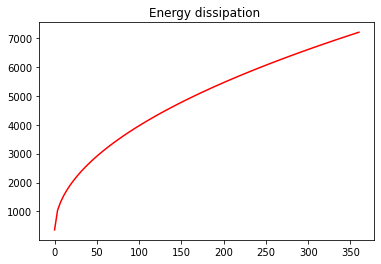

In [38]:

# Converted from kJ/m^2
def specific_energy_j_m2(t):
    return 7.2*(0.05+0.95*((t/360.0)**0.5))*1000.0 # J/m^2


t = np.linspace(0,360,100)

plt.plot(t,specific_energy_j_m2(t), 'r')
plt.title("Energy dissipation ")

specific_energy_j_m2(0)

In [7]:
# Or is it Table 7

In [223]:
pulse_t = np.linspace(0,1,int(repetition_freq*10))

guideline_energy_integral_J_m2 = 0
guideline_energy = []

pulse_energy_integral_J_m2 = 0
pulse_energy = []

for idx,t_ in enumerate(pulse_t[0:-1]):
    dt = (pulse_t[idx+1]-t_)
    
    pulse_energy_integral_J_m2 += pulse_RF_output_power_watts * dt / exposure_area

    
    guideline_energy_integral_J_m2 = (specific_energy_j_m2(t_))       
    guideline_energy.append(guideline_energy_integral_J_m2)
    pulse_energy.append(pulse_energy_integral_J_m2)

#wait, we could have just symbolically integrated this. oh well. 
#I guess this is more flexible in terms of step response? Nah, just being dumb.
#no, wait, isn't that equation already an integral over energy?

plt.plot(pulse_t[0:-1], guideline_energy[0:-1], 'r')
plt.plot(pulse_t[0:-1], pulse_energy[0:-1], 'g')

pulse_energy_integral * repetition_freq


NameError: name 'repetition_freq' is not defined

In [40]:
pulse_energy_density_J_m2 = exposure_flux_w_m2 * pulse_duration #W/m^2
# a typical value for the energy is 20 millijoules / m^2
# see \cite{Radiation1996}

pulse_energy_density_J_m2

0.01

In [24]:
#First-order Penetration depth from 
# Osepchuk
# Raymond Kwok
# and Hand
# might have the wrong formula, however.
input_field = 50000.0
required_field = 300.0

factor = required_field/input_field

#Hand 1982 
# 40 mm for dry tissue,
# 5 mm for wet 
# at 8 GHz.
gamma = 0.005

depth = log(1.0/(factor))*gamma # this is not right.
depth*1000.0



25.57997904877041

Transmission coefficient of the field magnitude of a wave propagating from medium $n_1$ to $n_2$ is \cite{MIT6} 

$$t = \frac{2 n_1}{n_1 + n_2} $$

where the refractive index $n$ is 

$$n = \sqrt{\frac{\mu}{\epsilon}}$$




The conductivity of the lung changes significantly as it is inflated.


The complex permittivity is given by:

$$\epsilon(\omega)=\epsilon'(\omega)+j\epsilon''(\omega)=\epsilon_r(\omega)\epsilon_0+j\frac{\sigma(\omega)}{\omega},\tag{1}$$


Emilio Pisanty (https://physics.stackexchange.com/users/8563/emilio-pisanty), The relation between permittivity and conductivity, URL (version: 2018-06-19): https://physics.stackexchange.com/q/67084

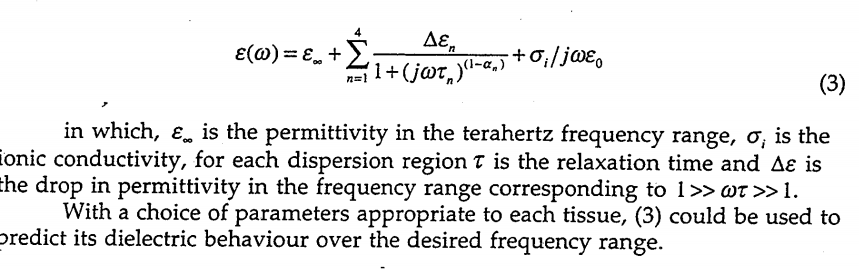

Note the ambiguity in the addition - is that inside the sum?
Apparently not.

In [268]:


def cole_cole_4(center_frequency, ef, sigma, deltas, alphas, taus):
    '''
    See "Compilation of the dielectric properties of body tissues at RF and microwave frequencies.", Gabriel 1996
    Equation 3, page 12.
    '''
    angular_frequency = 2.0*pi*center_frequency
    
    complex_permittivity = complex(ef, 0)
    
    for n in range(0, 4):
        complex_permittivity += deltas[n] / (1.0 + ((complex(0, 1)*angular_frequency*taus[n])**(1.0-alphas[n])))

    complex_permittivity += (sigma/((complex(0, 1)*angular_frequency*epsilon_0)))

    return complex_permittivity

def complex_permittivity_to_er_and_sigma(complex_permittivity, center_frequency):
    angular_frequency = 2.0*pi*center_frequency
    
    relative_permittivity = complex_permittivity.real
    conductivity = abs(complex_permittivity.imag*((angular_frequency*epsilon_0)))
    
    return relative_permittivity, conductivity
    
    

blood = cole_cole_4(2.99e9, 4.0, 7e-1, [5.6e+1, 5.2e+3, 0, 0], [1e-1, 1e-1, 2e-1, 0], \
                           [8.37e-12, 1.32e-7,1.59e-4,1.592e-2])
blood_perm, blood_cond = complex_permittivity_to_er_and_sigma(blood, 2.99e9)

assert(isclose(blood_perm, 5.74E+1, rel_tol=0.1)) #Blood!
assert(isclose(blood_cond, 3.04E+0, rel_tol=0.1)) #Blood!



# Q

While we're here, what's the max. Q. value in any human tissue, derived from the relaxation time?

In [101]:

(2 * pi * 8e9 * (8.377e-12))/2



0.21053697327297358

Of course, this is the 'aggregate' Q, over a large number of different cells, so it's not really that meaningful.



# Line

Drawing a line through the "Duke" model in paraview and then saving to CSV, we get:




In [264]:
line_file = '../biology/FDTD/chunks/line.csv'
line = np.genfromtxt(open(line_file, "r"), delimiter=",", dtype=np.float, encoding='ascii', skip_header=1)
#column 0 is tissue ID, 2 is position (m)

line = line[line[:,0]!=0] # remove air gap

In [285]:

def electric_field_penetration_depth(center_frequency, relative_permittivity, conductivity):
    #from Hand, 1982
    
    angular_frequency = 2.0*pi*center_frequency
    
    d = (1.0 / angular_frequency)
    mid = ((relative_permittivity*mu_0*epsilon_0)/2.0)
    mid *= (sqrt(1.0+((conductivity/(angular_frequency*epsilon_0*relative_permittivity))**2.0))-1)
    mid = (mid)**(-1.0/2.0)
    
    return d*mid
    
depth = electric_field_penetration_depth(2.99e9, 57.37, 3.04)

#Blood penetration depth from 
#http://niremf.ifac.cnr.it/tissprop/htmlclie/htmlclie.php
assert(isclose(depth, 0.01339, rel_tol=0.001)) 



https://en.wikipedia.org/wiki/Penetration_depth:

According to \href{Beer-Lambert_law}{Beer-Lambert law}, the intensity of
an electromagnetic wave inside a material falls off exponentially from
the surface as


$$I(z) = I_0 \, e^{-\alpha z}$$

If $\delta_p$ denotes the penetration depth, we have

$$\delta_p = \frac{1}{\alpha}$$

Penetration depth is one term that describes the decay of
electromagnetic waves inside of a material. The above definition refers
to the depth $\delta_p$ at which the intensity or power of the field
decays to 1/e of its surface value. In many contexts one is
concentrating on the field quantities themselves: the electric and
magnetic fields in the case of electromagnetic waves. Since the power of
a wave in a particular medium is proportional to the \emph{square} of a
field quantity, one may speak of a penetration depth at which the
magnitude of the electric (or magnetic) field has decayed to 1/e of its
surface value, and at which point the power of the wave has
thereby decreased to $1/e^2$ or about 13\% of its surface value:

$$\delta_e = \frac{1}{\alpha/2}  = \frac{2}{\alpha}  =  2 \delta_p$$

Note that $\delta_e$ is identical to the \href{skin_depth}{skin
depth}, the latter term usually applying to metals in reference to the
decay of electrical \href{Electric_current}{currents} (which follow the
decay in the electric or magnetic field due to a plane wave incident on
a bulk conductor). The attenuation constant \(\alpha/2\) is also
identical to the (negative) real part of the
\href{propagation_constant}{propagation constant}, which may also be
referred to as \(\alpha\) using a notation inconsistent with the above
use. When referencing a source one must always be careful to note
whether a number such as \(\alpha\) or \(\delta\) refers to the decay of
the field itself, or of the intensity (power) associated with that
field. It can also be ambiguous as to whether a positive number
describes \url{attenuation} (reduction of the field) or
\href{Gain_(electronics)}{gain}; this is usually obvious from the
context.


(converted with pandoc --from mediawiki --to latex)

From http://niremf.ifac.cnr.it/tissprop/htmlclie/htmlclie.php


D.Andreuccetti, R.Fossi and C.Petrucci: An Internet resource for the calculation of the dielectric properties of body tissues in the frequency range 10 Hz - 100 GHz. IFAC-CNR, Florence (Italy), 1997. Based on data published by C.Gabriel et al. in 1996. [Online]. Available: http://niremf.ifac.cnr.it/tissprop/

They mention both "penetration depth" and "skin depth".



\cite{Safety2001}

The penetration depth δ, i.e., the distance from the boundary of a medium to the point at which the field strengths or induced current
densities have been reduced to 1/e of their initial
boundary value in the medium, is given by (2) for a
plane-wave incident on a planar surface.



In [294]:
def electric_field_factor_at_depth(penetration_depth, depth):
    ''''''
    return exp(- depth / penetration_depth)
    
    
electric_field_factor_at_depth(depth, 0.01339)

0.367877855412247

<KeysViewHDF5 ['Tissues', 'Version']>


In [269]:

# the material ids file generated through the IT.IS ViP "Virtual Family Tool" includes all the tissues in order, 
# not only those present in the chunk.
# Some tissues need to be manually chosen.

def lookup_tissue_properties(id):
    #this file gets you the names from the IDs.
    material_ids_file = '../biology/FDTD/chunks/2mm_100x100x50_left_lung_4.txt'
    ids_names = np.genfromtxt(open(material_ids_file, "r"), delimiter="\t", dtype=None, encoding='ascii', skip_footer=7)
    
    #This file gets you the 
    tissue_properties_database_file = '../biology/FDTD/itis_tissue_properties/SEMCAD_v14.8.h5'

    with h5py.File(tissue_properties_database_file,'r') as hf:
        print(hf.keys())
    #     print(hf['0']['2']['_Object'][''])


import nexusformat.nexus as nx

#f = nx.nxload(tissue_properties_database_file)
#print(f['Tissues'].tree)


#using the Sim4Life H5 database because it includes the IDs





# Tau values in the tissueprop files are normalized
# Tau1 is normalized by 1e-12
# tau2 1e-9
# tau3 1e-6
# tau4 1e-3
# normalization_factors = np.array([1e-12, 1e-9, 1e-6, 1e-3])
# all other constants are not normalized.

